# Match tensor v2
## NOTE: no where close to fully functional.

In [197]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.layers import Conv2D
from keras.layers.merge import dot, multiply, add, concatenate
from keras.layers import Merge
from keras.layers.core import Lambda,Reshape, Flatten
from keras.layers.pooling import GlobalMaxPooling2D
from keras.models import Model
from keras.backend import transpose,batch_dot,expand_dims
from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
from keras.layers.wrappers import TimeDistributed

In [2]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec.model'
vocab_path='model/word2vec_vocab.json'
embeddings_path='model/embeddings.npz'

In [3]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term']


In [5]:
#transform attribute into doc
dp = DataPreprocessing()
attribute_doc_df = dp.getAttributeDoc(attribute_df)
#attribute_doc_df
product_df=product_df.join(attribute_doc_df.set_index('product_uid'), on = 'product_uid')

In [6]:
# product_df['content'] = train_query_df['search_term'].map(str) + " " + \
#                         product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) + " " + \
#                         product_df['attr_json'].map(str)

product_df['content'] = product_df['product_title'].map(str) + " " + \
                        product_df['product_description'].map(str) 

# ## no attribute
# product_df['content'] = product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) 
        
#product_df['content']

In [9]:
### test data
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
test_private_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Private')#,savepath='../data/test_private_gold.csv')
test_public_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Public')# savepath='../data/test_public_gold.csv')

In [118]:

train_query_df = HomeDepotFeature().getFeature(train_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")
#,stopwords,stemming
#"spelling,nonascii" no diff.

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 6 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
search_term      74067 non-null object
relevance        74067 non-null float64
relevance_int    74067 non-null int64
product_idx      74067 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB
None


In [119]:
test_private_df = HomeDepotFeature().getFeature(test_private_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78419 entries, 2 to 147405
Data columns (total 4 columns):
id             78419 non-null int64
product_uid    78419 non-null int64
search_term    78419 non-null object
relevance      78419 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.0+ MB
None


In [120]:
test_public_df = HomeDepotFeature().getFeature(test_public_df, product_df, attribute_df, test_public_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.0 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33648 entries, 1 to 147404
Data columns (total 4 columns):
id             33648 non-null int64
product_uid    33648 non-null int64
search_term    33648 non-null object
relevance      33648 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.3+ MB
None


In [124]:
len(test_public_df)

33648

In [125]:
#https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors
def doc_to_wordlist( doc, remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    #review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    if remove_non_letters:
        doc = re.sub("[^a-zA-Z]"," ", doc)
    # 2a. remove non-letters, numbers
    if remove_non_letters_numbers:
        doc = re.sub("[^a-zA-Z0-9]"," ", doc)
    #
    # 3. Convert words to lower case and split them
    words = doc.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

#print(len(doc_to_wordlist(product_df['content'][0],remove_stopwords=True)))
#print(len(doc_to_wordlist(product_df['content'][0],remove_stopwords=False)))
#product_df['content'][0]

In [126]:
# # Download the punkt tokenizer for sentence splitting
import nltk.data
# nltk.download()   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [127]:
# Define a function to split a doc into parsed sentences
def doc_to_sentences( doc, tokenizer, remove_stopwords=False ):
    # Function to split a doc into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(doc.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( doc_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences


In [128]:
print(product_df['content'][100])
print(len(doc_to_wordlist(product_df['content'][100],remove_stopwords=True)))
#print(len(doc_to_wordlist(product_df['content'][0],remove_stopwords=False)))
print(doc_to_wordlist(product_df['content'][100],remove_stopwords=True))

Pelican Water 10 GPM Whole House Carbon Water Filter System for Homes with 1-3 Bathrooms The PC600 Pelican Premium 10 GPM Whole House Carbon Water Filter System For Homes With 1-3 Bathrooms is a deluxe, high-capacity, virtually maintenance-free system that is easily installed in any home and has a 600,000/5-year capacity. Only the top rated valves and tanks are used in manufacturing each Pelican system, backed by an industry-leading limited lifetime parts warranty. Imagine spring-like water through every faucet of your home. Drink, bathe and shower in sparkling clean water with no more dry itchy skin or unpleasant odors from chemicals. The large diameter of the tank holds a significant amount of water filtration carbon media, increasing the overall performance and lifespan, and the replacement cost is a fraction of the cost of similar items. When it comes time to replace the filter, all you have to do is replace the media inside the tank, with no plumbing required and no need to replac

In [129]:
# print(len(doc_to_sentences(product_df['content'][0],tokenizer,remove_stopwords=True)))
# print(len(doc_to_sentences(product_df['content'][0],tokenizer,remove_stopwords=False)))
# product_df['content'][0]

In [130]:
sentences = []  # Initialize an empty list of sentences
query_sentences = []
doc_sentences = []

print("Parsing sentences from search string")
for query in train_query_df["search_term"]:
    query_sentences += [doc_to_wordlist(query, remove_stopwords=True)]

print("Parsing sentences from unlabeled set")
for doc in product_df['content']:
    doc_sentences += [doc_to_wordlist(doc, remove_stopwords=True)]

sentences = query_sentences+doc_sentences    

Parsing sentences from search string
Parsing sentences from unlabeled set


In [131]:
len(sentences)

198495

In [132]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100#50#300    # Word vector dimensionality                      
min_word_count = 1#5#40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 0 #1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
word2vec_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
word2vec_model.save(word2vec_model_path)

2017-04-04 14:37:34,664 : INFO : collecting all words and their counts
2017-04-04 14:37:34,665 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-04 14:37:34,675 : INFO : PROGRESS: at sentence #10000, processed 27305 words, keeping 3158 word types
2017-04-04 14:37:34,683 : INFO : PROGRESS: at sentence #20000, processed 54948 words, keeping 4257 word types
2017-04-04 14:37:34,702 : INFO : PROGRESS: at sentence #30000, processed 82693 words, keeping 4718 word types
2017-04-04 14:37:34,711 : INFO : PROGRESS: at sentence #40000, processed 109758 words, keeping 4991 word types
2017-04-04 14:37:34,720 : INFO : PROGRESS: at sentence #50000, processed 136925 words, keeping 5192 word types
2017-04-04 14:37:34,730 : INFO : PROGRESS: at sentence #60000, processed 168240 words, keeping 5608 word types
2017-04-04 14:37:34,744 : INFO : PROGRESS: at sentence #70000, processed 201592 words, keeping 5829 word types


Training model...


2017-04-04 14:37:34,881 : INFO : PROGRESS: at sentence #80000, processed 820201 words, keeping 40419 word types
2017-04-04 14:37:35,104 : INFO : PROGRESS: at sentence #90000, processed 1805194 words, keeping 72669 word types
2017-04-04 14:37:35,318 : INFO : PROGRESS: at sentence #100000, processed 2783421 words, keeping 95967 word types
2017-04-04 14:37:35,530 : INFO : PROGRESS: at sentence #110000, processed 3744111 words, keeping 115166 word types
2017-04-04 14:37:35,746 : INFO : PROGRESS: at sentence #120000, processed 4723634 words, keeping 132548 word types
2017-04-04 14:37:35,961 : INFO : PROGRESS: at sentence #130000, processed 5687008 words, keeping 146974 word types
2017-04-04 14:37:36,181 : INFO : PROGRESS: at sentence #140000, processed 6625643 words, keeping 162974 word types
2017-04-04 14:37:36,395 : INFO : PROGRESS: at sentence #150000, processed 7569832 words, keeping 176778 word types
2017-04-04 14:37:36,609 : INFO : PROGRESS: at sentence #160000, processed 8509922 word

In [133]:
print(len(word2vec_model.wv.vocab))
#word2vec_model.wv.vocab

228804


In [134]:
print(word2vec_model.most_similar('wood', [], 3))
#print(word2vec_model.most_similar('temperature'))

[('hardwoods', 0.5958949327468872), ('pine', 0.5781776905059814), ('hardwood', 0.5520675778388977)]


In [135]:
# #w2v=Feature_Word2Vec(modelFilename=word2vec_model_path)#modelFilename=word2vec_model_path
# w2v=Feature_Word2Vec()
# #sentences=w2v.convertDFIntoSentences(product_df,'content')
# #print(sentences)
# w2v.trainModel(sentences)

In [136]:
# len(w2v.model.wv.vocab)

In [137]:
# w2vExpand=Word2VecQueryExpansion(modelFilename=word2vec_model_path)
# query="cooking"
# print("Expanding query: ")
# print(w2vExpand.getExpandedQuery(query,maxNoOfAdditionalWords=2,minSimilarityLevel=0.65,))

In [138]:
# print(w2v.getVectorFromWord('wood'))
# print(w2v.getSimilarWordVectors('wood',5))
# print(len(w2v.getVectorFromWord('wood')))

# embeddings to keras
http://ben.bolte.cc/resources/embeddings/embeddings.html

In [139]:
#vocab = dict([(k, v.index) for k, v in w2v.model.wv.vocab.items()])
#vocab = dict([(k, v.index) for k, v in word2vec_model.wv.vocab.items()])
vocab = dict([(k, v.index+1) for k, v in word2vec_model.wv.vocab.items()]) # Leave room for <pad>
vocab['<PAD>']=0
with open(vocab_path, 'w') as f:
    f.write(json.dumps(vocab))

In [140]:
#weights = w2v.model.wv.syn0
weights = word2vec_model.wv.syn0
np.save(open(embeddings_path, 'wb'), weights)

In [141]:
def load_vocab(vocab_path):
    """
    Load word -> index and index -> word mappings
    :param vocab_path: where the word-index map is saved
    :return: word2idx, idx2word
    """

    with open(vocab_path, 'r') as f:
        data = json.loads(f.read())
    word2idx = data
    idx2word = dict([(v, k) for k, v in data.items()])
    return word2idx, idx2word

In [142]:
word2idx, idx2word = load_vocab(vocab_path)

In [143]:
def word2vec_embedding_layer(embeddings_path):
    """
    Generate an embedding layer word2vec embeddings
    :param embeddings_path: where the embeddings are saved (as a numpy file)
    :return: the generated embedding layer
    """

    saved_weights = np.load(open(embeddings_path, 'rb'))
    padding_weight = np.zeros(num_features)
    padding_weight=np.expand_dims(padding_weight,axis=0)
    weights=np.concatenate((padding_weight,saved_weights), axis=0)
    layer = Embedding(input_dim=weights.shape[0], output_dim=weights.shape[1], weights=[weights],mask_zero=True, trainable=False)
    return layer

In [144]:
# a = np.load(open(embeddings_path, 'rb'))
# b = np.zeros(50)
# b=np.expand_dims(b,axis=0)
# b.shape

In [145]:
# c=np.concatenate((b,a), axis=0)
# c[0:2]

In [146]:
# idx2word = []
# idx2word=[dict([(v, k) for k, v in word2idx.items()])]
# idx2word.insert(0, '<PAD>')

In [147]:
idx2word[0]

'<PAD>'

In [148]:
print_tokens=False

In [149]:
# variable arguments are passed to gensim's word2vec model
# if options.train:
#     print('Training Word2Vec...')
#     create_embeddings(options.data, options.embeddings, options.vocab, size=100, min_count=5, window=5, sg=1, iter=25)

word2idx, idx2word = load_vocab(vocab_path)

if print_tokens:
    print('Tokens:', ', '.join(word2idx.keys()))



# convert to idx

In [150]:
len(word2idx.keys())

228805

In [151]:
#todo need to pass in word2idx
def convert_word2idx(word,verbose=False):
    if verbose:
        print("word: {}".format(word))
    if word not in word2idx.keys():
        return 0
    else:
        return word2idx[word]

In [152]:
#convert_word2idx('bracket')
for word in doc_sentences[100]:
    idx=convert_word2idx(word)
    print(idx)

8649
10
1290
1448
519
1013
10
231
38
1184
1098
2808
8649
166
1290
1448
519
1013
10
231
38
1184
1098
1510
16
240
880
253
69
38
86
212
11
49
240
52
481
1284
3007
20
1238
8649
38
990
603
1395
126
136
399
48
6117
609
268
10
356
128
11
5660
8138
53
4088
32
10
252
14905
1864
8362
1632
1393
133
429
550
847
4095
1263
10
1344
1013
1382
3682
1088
103
5542
270
487
2983
487
1913
342
159
98
948
231
948
1382
318
550
788
214
138
948
1015
550
2363
166
73
7
401
76
140
102
4998
52414
1013
195
231
18
23255
8
161
261
122
2460
1811
1533
52415
231
1382
792
3014
190
231
356
1788
5935
1830
550
1382
356
1396
206
3147
550
1382
136
1382
384
34142
3014
190
231
38
204
52416
3850
1382
4064
5466
40914
331
972
10
515
2130


In [153]:
def query_sent2idx(sentences):
    query_word2vec_idx_list=[]
    queries=sentences #w2v.convertDFIntoSentences(df,col)
    print(len(queries))
    for query in queries:
        idx_list = []
        for word in query:
#             if word not in word2idx.keys():
#                 idx_list+=[0]#[len(word2idx.keys())] # use last as special key #TODO: well we need to fix this. Using 0 for now so it's in range To OOV or something random
#             else:
#                 idx_list+=[word2idx[word]]
            idx_list+=[convert_word2idx(word)]
        query_word2vec_idx_list+=[idx_list]
        #print("=====")
        #print(idx_list)
        #print("=====")
    return query_word2vec_idx_list


In [154]:
#query_word2vec_idx_list = query_sent2idx(train_query_df['search_term'])
query_word2vec_idx_list = query_sent2idx(query_sentences)
#print(query_word2vec_idx_list)

74067


In [155]:
# def doc_sent2idx(df,col):
#     doc_word2vec_idx_list=[]
#     for row in df.iteritems():
#         a=w2v.convertDFIntoSentences(row,col)
#         print(a)
# #    print(len(queries))
# #     for query in queries:
# #         idx_list = []
# #         for word in query:
# #             if word not in word2idx.keys():
# #                 idx_list+=[len(word2idx.keys())] # use last as special key
# #             else:
# #                 idx_list+=[word2idx[word]]
# #         query_word2vec_idx_list+=[idx_list]
# #         print("=====")
# #         print(idx_list)
# #         print("=====")
#     return doc_word2vec_idx_list

In [156]:
#TODO: this is fucked. just bodge for testing nn
#doc_word2vec_idx_list = query_sent2idx(product_df,'product_title')
joined_df=train_query_df.join(product_df.set_index('product_uid'), on='product_uid')

joined_doc_sentences=[]
for doc in joined_df['content']:
    joined_doc_sentences += [doc_to_wordlist(doc, remove_stopwords=True)]
    
doc_word2vec_idx_list = query_sent2idx(joined_doc_sentences)
#print(doc_word2vec_idx_list)

74067


In [157]:
len(joined_doc_sentences)

74067

In [158]:
doc_word2vec_idx_list[100]
#query_word2vec_idx_list[100]

[5293,
 4227,
 87,
 2435,
 173,
 769,
 1792,
 1189,
 2435,
 1792,
 473,
 926,
 356,
 11,
 968,
 1104,
 877,
 1595,
 810,
 55,
 2342,
 506,
 15,
 87,
 325,
 801,
 849,
 98,
 77,
 4,
 1572,
 59,
 598,
 21598,
 55,
 2342,
 1595,
 810,
 55,
 2342,
 801,
 849,
 98,
 139,
 114539,
 114540,
 1572,
 59,
 1887,
 1053,
 24184,
 94,
 35,
 176]

In [159]:
# # cosine similarity model
# print('Building model...')
# input_a = Input(shape=(1,), dtype='int32', name='input_a')
# input_b = Input(shape=(1,), dtype='int32', name='input_b')
# embeddings = word2vec_embedding_layer(embeddings_path)
# embedding_a = embeddings(input_a)
# embedding_b = embeddings(input_b)
# similarity = merge([embedding_a, embedding_b], mode='cos', dot_axes=2)
# model = Model(input=[input_a, input_b], output=similarity)
# model.compile(optimizer='sgd', loss='mse') # optimizer and loss don't matter


# word_a = 'wood'#raw_input('First word: ')
# if word_a not in word2idx:
#     print('"%s" is not in the index' % word_a)
# word_b = 'fan'#raw_input('Second word: ')
# if word_b not in word2idx:
#     print('"%s" is not in the index' % word_b)
# output = model.predict([np.asarray([word2idx[word_a]]), np.asarray([word2idx[word_b]])])
# print('%f' % output)

# Define model

In [160]:
query_min_len = len(min(query_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
doc_min_len = len(min(doc_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
query_max_len = 6 #covers 95.74% of the search lengths (see data exploration)
# find longest sub list
doc_max_len = 100 #len(max(doc_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
print(doc_max_len)
print(query_max_len)
print(doc_min_len)
print(query_min_len)

100
6
21
0


In [161]:
lengths=[]
for i in doc_word2vec_idx_list:
    lengths+=[len(i)]

(array([  3.56000000e+02,   3.86600000e+03,   7.71000000e+03,
          1.03650000e+04,   8.56200000e+03,   8.24900000e+03,
          6.47000000e+03,   6.07100000e+03,   4.60200000e+03,
          3.24100000e+03,   3.14600000e+03,   2.23600000e+03,
          1.99000000e+03,   1.55000000e+03,   1.20900000e+03,
          1.04300000e+03,   7.84000000e+02,   5.66000000e+02,
          3.57000000e+02,   3.56000000e+02,   2.65000000e+02,
          2.18000000e+02,   1.43000000e+02,   1.29000000e+02,
          1.28000000e+02,   7.30000000e+01,   8.70000000e+01,
          6.10000000e+01,   2.60000000e+01,   5.30000000e+01,
          3.60000000e+01,   1.30000000e+01,   2.60000000e+01,
          7.00000000e+00,   1.00000000e+01,   1.70000000e+01,
          2.00000000e+00,   1.40000000e+01,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   8.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   6.00000000e+00,   1.00000000e+00,
        

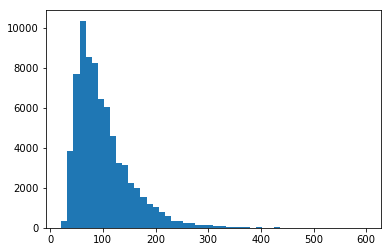

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lengths,bins=50)

In [324]:
#TODO testing
#doc_max_len=doc_min_len
print('Building model...')

def get_R(x):
    a, b = x.values()
    return K.dot(a, b)


embeddings = word2vec_embedding_layer(embeddings_path)

#embedding lookup
# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
# TODO: OOV embedding
input_query = Input(shape=(query_max_len,), dtype='int32', name='input_query')
input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
input_exact_match = Input(shape=(query_max_len,doc_max_len), dtype='float32', name='input_exact_match')
input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
embedding_query = embeddings(input_query)  # (None, 6, 100)
embedding_doc = embeddings(input_doc)      # (None, 400, 100)

#shared linear projection
shared_lp = Dense(40,activation='linear')
query_output = shared_lp(embedding_query) # (None, 6, 40) 
doc_output = shared_lp(embedding_doc) #(None, 400, 40) 

#query: bi LSTM, lp -- implementation = 0 for CPU option, 1 or 2 for GPU
query_output = Bidirectional(LSTM(30, dropout=0.0, implementation=2, return_sequences=True, go_backwards=True,use_bias=True,unit_forget_bias=True,)\
                             ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
                            )(query_output) #(None, 6, 30) unless concat (None, 6, 60)  
query_output = Dense(50,activation='linear')(query_output) #(None, 50)

#doc: bi LSTM, lp
doc_output = Bidirectional(LSTM(30, dropout=0.0, implementation=2, return_sequences=True, go_backwards=True,use_bias=True,unit_forget_bias=True,)\
                             ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
                            )(doc_output) #(None, 6, 400) unless concat (None, 6, 800)  
doc_output = Dense(50,activation='linear')(doc_output) #(None, 50)

#2d product
#mt_input = batch_dot(query_output,doc_output,axes=None) #axes=[2,2])
#query_output = Flatten()(query_output)
#doc_output = Flatten()(doc_output)
#mt_input = multiply([query_output, doc_output])
#mt_input = dot([query_output, doc_output], axes=(0), normalize=False)  
dot_product_output = dot([query_output, doc_output], axes=(2), normalize=True)  
#output is (11, 6, 400), where did 50 go?
def func_expand_dims(x):
    return expand_dims(x, axis=-1)

def expand_dims_output_shape(input_shape):
    return (input_shape[0], input_shape[1],input_shape[2],1)

mt_input_1 = Lambda(func_expand_dims, expand_dims_output_shape)(dot_product_output)

#mt_input = dot([transpose(query_output), transpose(doc_output)], axes=(0), normalize=False)  
######################################

def state_layer_dot_prod(x):
    output_list=[]
#    output = dot([x[0], x[1]], axes=(2), normalize=False)  
    for i in range(50):
        print(i)
        print(x[0][i])
        print(x[1][i])
        #output = multiply([transpose(x[0][i]), x[1][i]])
        #output_list += output
        #output = dot([x[0][i], transpose(x[1][i])])
        #transpose(x[1][i])
    print(output_list)
    return output_list

def state_layer_dot_prod_shape(input_shape):
    'Merge output shape'
    shape = list(input_shape)
    #print(input_shape)
    #print(shape)
    outshape = (shape[0][0],shape[1][1],shape[0][1],shape[0][2])
    #print(outshape)
    return tuple(outshape)

######################################
#mt_input = Lambda(state_layer_dot_prod,output_shape=state_layer_dot_prod_shape)([transpose(query_output), transpose(doc_output)])
#mt_input = Lambda(state_layer_dot_prod,output_shape=state_layer_dot_prod_shape)([query_output, doc_output])

##TODO fix error:
#InvalidArgumentError: Input to reshape is a tensor with 4800 values, but the requested shape requires a multiple of 120000
#[[Node: reshape_23/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](lambda_40/dot_42/MatMul, reshape_23/Reshape/shape)]]
#mt_input = Reshape((doc_max_len, query_max_len,50))(mt_input)

#Append exact match channel
output_exact_match = Dense(doc_max_len,activation='linear')(input_exact_match)
mt_input_2 = Lambda(func_expand_dims, expand_dims_output_shape)(output_exact_match)
# mt_input = concatenate([mt_input_1,mt_input_2],axis=0)
mt_input = concatenate([mt_input_1,mt_input_2],axis=3)
#TODO testing
#mt_input = mt_input_1

# Conv layers 1
output1 = Conv2D(filters=18, kernel_size=(3, 3), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

output2 = Conv2D(filters=18, kernel_size=(3, 4), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

output3 = Conv2D(filters=18, kernel_size=(3, 5), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

# Conv layers 2
output1 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output1)

output2 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output2)

output3 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output3)

# Max pool layer
output1 = GlobalMaxPooling2D(data_format='channels_last')(output1)
output2 = GlobalMaxPooling2D(data_format='channels_last')(output2)
output3 = GlobalMaxPooling2D(data_format='channels_last')(output3)

# Merge
output_combined = add([output1,output2,output3])
#TODO testing
#output_combined = output1

# Final layer
#output = Dense(1,activation='sigmoid')(output_combined)
#categorical
output = Dense(13, activation='softmax', kernel_initializer='glorot_uniform')(output_combined)


# build model
#model = Model([input_query], [query_output])
#model = Model([input_doc], [encoded_doc])
#model = Model([input_query,input_doc], [output1,output2,output3])
#model = Model([input_query,input_doc], [output_combined])
#model = Model([input_query,input_doc,input_exact_match], [query_output])
#model = Model([input_query,input_doc], [query_output,doc_output])
#model = Model([input_query,input_doc], [output])
#model = Model([input_query,input_doc,input_exact_match], [mt_input])
#model = Model([input_query,input_doc,input_exact_match], [mt_input_1,mt_input_2])
model = Model([input_query,input_doc,input_exact_match], [output])
#model = Model([input_query,input_doc,input_exact_match], [dot_product_output])


model.summary()

Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_query (InputLayer)         (None, 6)             0                                            
____________________________________________________________________________________________________
input_doc (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_10 (Embedding)         multiple              22880500                                     
____________________________________________________________________________________________________
dense_42 (Dense)                 multiple              4040                                         
_________________________________________________________________________

In [325]:
# #TODO SSM
# #doc_max_len=doc_min_len
# print('Building model...')

# def get_R(x):
#     a, b = x.values()
#     return K.dot(a, b)


# embeddings = word2vec_embedding_layer(embeddings_path)

# #embedding lookup
# # TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
# # TODO: OOV embedding
# input_query = Input(shape=(query_max_len,), dtype='int32', name='input_query')
# input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
# input_exact_match = Input(shape=(query_max_len,doc_max_len), dtype='float32', name='input_exact_match')
# input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
# embedding_query = embeddings(input_query)  # (None, 6, 100)
# embedding_doc = embeddings(input_doc)      # (None, 400, 100)

# #shared linear projection
# shared_lp = Dense(40,activation='linear')
# query_output = shared_lp(embedding_query) # (None, 6, 40) 
# doc_output = shared_lp(embedding_doc) #(None, 400, 40) 

# #query: bi LSTM, lp -- implementation = 0 for CPU option, 1 or 2 for GPU
# query_output = Bidirectional(LSTM(16, dropout=0.0, implementation=0, return_sequences=True, go_backwards=True)\
#                              ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
#                             )(query_output) #(None, 6, 30) unless concat (None, 6, 60)  
# query_output = Dense(50,activation='linear')(query_output) #(None, 50)

# #doc: bi LSTM, lp
# doc_output = Bidirectional(LSTM(64, dropout=0.0, implementation=0, return_sequences=True, go_backwards=True)\
#                              ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
#                             )(doc_output) #(None, 6, 400) unless concat (None, 6, 800)  
# doc_output = Dense(50,activation='linear')(doc_output) #(None, 50)

# #2d product
# #mt_input = batch_dot(query_output,doc_output,axes=None) #axes=[2,2])
# #query_output = Flatten()(query_output)
# #doc_output = Flatten()(doc_output)
# #mt_input = multiply([query_output, doc_output])
# #mt_input = dot([query_output, doc_output], axes=(0), normalize=False)  
# dot_product_output = dot([query_output, doc_output], axes=(2), normalize=True)  
# #output is (11, 6, 400), where did 50 go?
# def func_expand_dims(x):
#     return expand_dims(x, axis=-1)

# def expand_dims_output_shape(input_shape):
#     return (input_shape[0], input_shape[1],input_shape[2],1)

# mt_input_1 = Lambda(func_expand_dims, expand_dims_output_shape)(dot_product_output)


# # Merge
# #output_combined = add([output1,output2,output3])
# #TODO testing
# output1 = GlobalMaxPooling2D(data_format='channels_last')(mt_input_1)
# output_combined = output1


# # Final layer
# output = Dense(1,activation='sigmoid')(output_combined)
# #categorical
# #output = Dense(13, activation='softmax', kernel_initializer='glorot_uniform', use_bias=True)(output_combined)


# # build model
# #model = Model([input_query], [query_output])
# #model = Model([input_doc], [encoded_doc])
# #model = Model([input_query,input_doc], [output1,output2,output3])
# #model = Model([input_query,input_doc], [output_combined])
# #model = Model([input_query,input_doc,input_exact_match], [query_output])
# #model = Model([input_query,input_doc], [query_output,doc_output])
# #model = Model([input_query,input_doc], [output])
# #model = Model([input_query,input_doc,input_exact_match], [mt_input])
# #model = Model([input_query,input_doc,input_exact_match], [mt_input_1,mt_input_2])
# model = Model([input_query,input_doc,input_exact_match], [output])


# model.summary()

In [326]:
# # from keras.layers import Input, merge
# # from keras.models import Model
# # import numpy as np

# # input_a = np.reshape([[1, 2, 3],[1, 2, 3],],[[1, 2, 3],[1, 2, 3]])
# # input_b = np.reshape([4, 5, 6], (1, 1, 3))

# # print(input_a)
# # print(input_b)
# # a = Input(shape=(1, 3))
# # b = Input(shape=(1, 3))

# # concat = merge([a, b], mode='concat', concat_axis=-1)
# # dot = merge([a, b], mode='dot', dot_axes=2)
# # cos = merge([a, b], mode='cos', dot_axes=2)

# # model_concat = Model(input=[a, b], output=concat)
# # model_dot = Model(input=[a, b], output=dot)
# # model_cos = Model(input=[a, b], output=cos)

# # print(model_concat.predict([input_a, input_b]))
# # print(model_dot.predict([input_a, input_b]))
# # print(model_cos.predict([input_a, input_b]))

# from keras import backend as K
# x_batch = K.ones(shape=(11, 6,50 ))
# y_batch = K.ones(shape=(11, 400,50))
# x_batch=K.batch_flatten(x_batch)
# y_batch=K.batch_flatten(y_batch)
# #xy_batch_dot = K.dot(transpose(y_batch),x_batch )#, axes=[0,0])
# xy_batch_dot = K.batch_dot(x_batch,y_batch, axes=[0,0])
# K.int_shape(xy_batch_dot)
# # K.int_shape(x_batch)
# # K.int_shape(y_batch)



In [327]:
optimizer = optimizers.Adam(lr=0.001)
#optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, decay = 0.0, nesterov = True)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [328]:
x_query_train=np.array(query_word2vec_idx_list)[0:74067]
x_doc_train=np.array(doc_word2vec_idx_list)[0:74067]#[0:len(x_query_train)]

# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
print("Pad sequences (samples x time)")
x_query_train = sequence.pad_sequences(x_query_train, maxlen=query_max_len,padding='post', truncating='post', value=0.)
x_doc_train = sequence.pad_sequences(x_doc_train, maxlen=doc_max_len,padding='post', truncating='post', value=0.)
# x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len)
# x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len)

print('x_query_train shape:', x_query_train.shape)
print('x_doc_train shape:', x_doc_train.shape)
# print('x_query_test shape:', x_query_test.shape)
# print('x_doc_test shape:', x_doc_test.shape)

#TODO: y label on 0-1 scale from 1-3
#y_train=(train_query_df['relevance'].as_matrix()-1)/3

# TODO: as categorical
y_train=to_categorical(train_query_df['relevance_int'].as_matrix(),13)
# y_test=test_query_df['relevance_int'].as_matrix()
print('y_train shape:', y_train.shape)

Pad sequences (samples x time)
x_query_train shape: (74067, 6)
x_doc_train shape: (74067, 100)
y_train shape: (74067, 13)


In [329]:
len(max(query_word2vec_idx_list,key=len)) 
len(max(x_query_train,key=len)) 

6

In [330]:
x_doc_train[100]
y_train[100]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [331]:
exact_match_list=[]
for i in range(x_query_train.shape[0]):
    #print(i)
    c1=x_query_train[i]
    c2=x_doc_train[i]
    #print(c1.shape[0])
    #print(c2.shape[0])

    c1_inp=np.repeat(c1,c2.shape[0],axis=0)
    c1_inp=c1_inp.reshape((c1.shape[0],c2.shape[0]))
    #print(c1_inp.shape)
    #print(c1_inp)

    #print(c2)
    c2_inp=np.tile(c2,(c1.shape[0],1))
    #print(c2_inp.shape)
    #print(c2_inp)    
    #print(c1_inp == c2_inp)
    exact_match_list+=[(c1_inp == c2_inp).astype(int)]

In [332]:
exact_match_inp_train=np.array(exact_match_list)

In [333]:
exact_match_inp_train.shape

(74067, 6, 100)

In [334]:
print(train_query_df['search_term'][0])
print(product_df['product_title'][0])
print(x_query_train[i])
print(x_doc_train[i])
print(exact_match_inp_train[0])


angle bracket
simpson strong tie 12 gauge angle
[ 882 4970 1440 2326    0    0]
[16197   777   457 13755 15331 15855   711  4970  1440   108    70     1
   411 13755 15331 15855   711   626  4970  1440  2065    90   388  3839
   873   180   169   799  1483   896   584     6  2513   231    32   271
    50  1474   622    52     8    20    54   193  1440   456  1394   433
  3643  6746    46  4970   108  2513  1027 16894  3113   622    52 23494
 40170  2276   109   510 40171  1440   108     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0

In [335]:
batch_size=300#2 #200
print('Train...')
hist=model.fit([x_query_train,x_doc_train,exact_match_inp_train], [y_train],
          batch_size=batch_size,
          epochs=10,
          validation_split=0.2,
          shuffle=True,
          verbose=2,
          #validation_data=[x_test, y_test])
         )


Train...
Train on 59253 samples, validate on 14814 samples
Epoch 1/10
99s - loss: 0.0626 - acc: 0.2709 - val_loss: 0.0653 - val_acc: 0.1844
Epoch 2/10
92s - loss: 0.0605 - acc: 0.3117 - val_loss: 0.0644 - val_acc: 0.2054
Epoch 3/10
90s - loss: 0.0600 - acc: 0.3202 - val_loss: 0.0649 - val_acc: 0.2037
Epoch 4/10
91s - loss: 0.0594 - acc: 0.3264 - val_loss: 0.0654 - val_acc: 0.1952
Epoch 5/10
96s - loss: 0.0590 - acc: 0.3353 - val_loss: 0.0642 - val_acc: 0.2147
Epoch 6/10
117s - loss: 0.0586 - acc: 0.3390 - val_loss: 0.0648 - val_acc: 0.2191
Epoch 7/10
104s - loss: 0.0582 - acc: 0.3435 - val_loss: 0.0638 - val_acc: 0.2338
Epoch 8/10
95s - loss: 0.0579 - acc: 0.3505 - val_loss: 0.0645 - val_acc: 0.2271
Epoch 9/10
110s - loss: 0.0575 - acc: 0.3559 - val_loss: 0.0640 - val_acc: 0.2332
Epoch 10/10
135s - loss: 0.0572 - acc: 0.3641 - val_loss: 0.0642 - val_acc: 0.2288


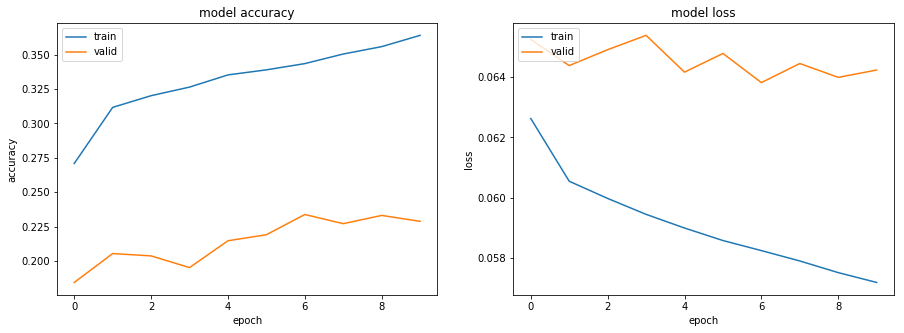

In [336]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [337]:
batch_size=200 #200
prediction=model.predict([x_query_train,x_doc_train,exact_match_inp_train],
          batch_size=batch_size,
         )

In [338]:
prediction.shape

(74067, 13)

In [339]:
prediction[0]

array([  2.49889530e-02,   3.30214709e-04,   2.22766008e-02,
         9.46527289e-05,   4.52328771e-02,   7.59399671e-04,
         8.27541351e-02,   1.66393176e-04,   1.50801823e-01,
         2.23548905e-05,   2.54998535e-01,   3.12221207e-04,
         4.17261809e-01], dtype=float32)

In [340]:
def pred2relevance(prediction):
    orig_labels = [ 1.  ,  1.25 , 1.33 , 1.5 ,  1.67,  1.75,  2. ,   2.25 , 2.33  ,2.5 ,  2.67  ,2.75 ,3.  ]
    new_labels= [ 0 , 1 , 2 , 3 , 4 , 5,  6 , 7 , 8,  9, 10 ,11, 12]
    orig_labels_prediction=[]
    for preds in prediction:
        #print(preds)
        max_idx=np.argmax(preds)
        orig_labels_prediction+=[orig_labels[max_idx]]
    return np.array(orig_labels_prediction)

In [341]:
orig_labels_prediction =  pred2relevance(prediction)

In [342]:
orig_labels_prediction[0]

3.0

In [343]:
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(train_query_df['relevance'].as_matrix(), orig_labels_prediction)**0.5

In [344]:
RMSE

0.59375040995940442

# print("Predict")
word_a = 'wood'#raw_input('First word: ')
if word_a not in word2idx:
    print('"%s" is not in the index' % word_a)
word_b = 'fan'#raw_input('Second word: ')
if word_b not in word2idx:
    print('"%s" is not in the index' % word_b)
output = model.predict([np.asarray([word2idx[word_a]]), np.asarray([word2idx[word_b]])])
print('%f' % output)

In [345]:
test_df=test_private_df

In [346]:
test_query_sentences = []

print("Parsing sentences from search string")
for query in test_df["search_term"]:
    test_query_sentences += [doc_to_wordlist(query, remove_stopwords=True)]
    

Parsing sentences from search string


In [347]:
len(test_query_sentences)

78419

In [348]:
test_query_word2vec_idx_list = query_sent2idx(test_query_sentences)

78419


In [349]:
test_joined_df=test_df.join(product_df.set_index('product_uid'), on='product_uid')

test_joined_doc_sentences=[]
for doc in test_joined_df['content']:
    test_joined_doc_sentences += [doc_to_wordlist(doc, remove_stopwords=True)]
    
test_doc_word2vec_idx_list = query_sent2idx(test_joined_doc_sentences)

78419


In [350]:
x_query_test=np.array(test_query_word2vec_idx_list)[0:78419]
x_doc_test=np.array(test_doc_word2vec_idx_list)[0:78419]

# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
print("Pad sequences (samples x time)")
x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len,padding='post', truncating='post', value=0.)
x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len,padding='post', truncating='post', value=0.)
# x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len)
# x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len)

print('x_query_test shape:', x_query_test.shape)
print('x_doc_test shape:', x_doc_test.shape)

#TODO: y label on 0-1 scale from 1-3
#y_train=(train_query_df['relevance'].as_matrix()-1)/3

# TODO: as categorical
#y_test=to_categorical(train_query_df['relevance_int'].as_matrix(),13)
# y_test=test_query_df['relevance_int'].as_matrix()
#print('y_train shape:', y_train.shape)

Pad sequences (samples x time)
x_query_test shape: (78419, 6)
x_doc_test shape: (78419, 100)


In [351]:
exact_match_list_test=[]
for i in range(x_query_test.shape[0]):
    #print(i)
    c1=x_query_test[i]
    c2=x_doc_test[i]
    #print(c1.shape[0])
    #print(c2.shape[0])

    c1_inp=np.repeat(c1,c2.shape[0],axis=0)
    c1_inp=c1_inp.reshape((c1.shape[0],c2.shape[0]))
    #print(c1_inp.shape)
    #print(c1_inp)

    #print(c2)
    c2_inp=np.tile(c2,(c1.shape[0],1))
    #print(c2_inp.shape)
    #print(c2_inp)    
    #print(c1_inp == c2_inp)
    exact_match_list_test+=[(c1_inp == c2_inp).astype(int)]

exact_match_inp_test=np.array(exact_match_list_test)
exact_match_inp_test.shape

(78419, 6, 100)

In [352]:
print(test_query_df['search_term'][0])
print(x_query_test[0])
print(x_doc_test[0])
print(exact_match_inp_test[0])

90 degree bracket
[1722 5130 1549    0    0    0]
[ 1722   369  1045   272   572  2838   144  1369  1941    77    36  1164
   813   981  1722   369  1045    58   117   158  2838  1006   389  5229
    59     6    81  1655   520  1459   562   514  4694 12149   433   365
    28   520   406  2411     2  9881   625   273  1093    36   264   361
   310    46  1191   263   413  1064   483   722  1006  1228    11   794
 34116  2010  2666   323  1241 34117   401  1369  4930   813 37211     1
     1    29   272  5502   264   310  6226   673   649     1   369   394
  3282   248     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [359]:
batch_size=300 #200
test_prediction=model.predict([x_query_test,x_doc_test,exact_match_inp_test],
          batch_size=batch_size,
         )

In [360]:
test_prediction.shape

(78419, 13)

In [361]:
test_prediction[0]

array([  2.42920481e-02,   4.53530311e-06,   3.65434587e-02,
         3.24295579e-05,   1.39181674e-01,   3.93238530e-04,
         4.35907900e-01,   4.15777176e-05,   2.15909958e-01,
         4.11668907e-06,   1.27853900e-01,   1.73360822e-04,
         1.96618717e-02], dtype=float32)

In [362]:
test_orig_labels_prediction =  pred2relevance(test_prediction)

In [363]:
test_orig_labels_prediction[0]

2.0

In [364]:
test_RMSE = mean_squared_error(test_df['relevance'].as_matrix(), test_orig_labels_prediction)**0.5
test_RMSE 

0.63874448062914368